In [1]:
%%sh
pip install -U -q transformers torch torchvision

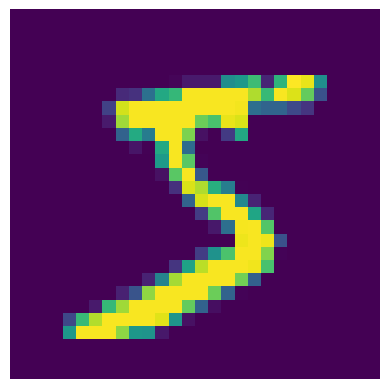

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import v2 as transforms
from matplotlib import pyplot as plt

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.1307,), (0.3081,))
])
batch_size = 5
kwargs = {'batch_size': batch_size}

dataset1 = MNIST("./data", train=True, download=True, transform=transform)
dataset2 = MNIST("./data", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **kwargs)

plt.imshow(dataset1[0][0].squeeze())
plt.axis("off")
plt.show()

In [3]:
import torch

from simple_model.pytorch_model import Model

device = "cuda" if torch.cuda.is_available() else "cpu"
net = Model()
net = net.to(device)
net

2024-09-20 14:03:01.199037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


Model(
  (lin0): Linear(in_features=784, out_features=10, bias=True)
  (act): Sigmoid()
)

In [4]:
import torch.nn.functional as F
import torch.optim as optim
from torch import zeros
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

EPOCH = 1

optimizer = optim.Adadelta(net.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
net.train()

for epoch in range(EPOCH):
    print(f"EPOC {epoch + 1}/{EPOCH}")
    for data, target in tqdm(train_loader):
        data, target_tensor = data.to(device), zeros(target.shape[0], 10).to(device)
        for batch_id, idx in enumerate(target):
            target_tensor[batch_id, idx] = 1.0
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target_tensor)
        loss.backward()
        optimizer.step()

EPOC 1/1


100%|██████████| 12000/12000 [00:46<00:00, 259.77it/s]


In [5]:
import torch
from tqdm import tqdm

net.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in tqdm(test_loader):
        target = target.to(device)
        data, target_tensor = data.to(device), zeros(target.shape[0], 10).to(device)
        for batch_id, idx in enumerate(target):
            target_tensor[batch_id, idx] = 1.0
        output = net(data)
        test_loss += F.cross_entropy(output, target_tensor, reduction='sum').item()  # sum up batch loss
        pred = net.get_guess(output)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

torch.save(net.state_dict(), "simple_model.pth")

100%|██████████| 2000/2000 [00:05<00:00, 374.99it/s]


Test set: Average loss: 1.5931, Accuracy: 8987/10000 (90%)



In [6]:
from IPython.display import display
from torchvision.datasets import MNIST

data = MNIST('./data')
test = [data[0][0], data[1][0]]

display(test[0])
display(test[1])

In [7]:
from simple_model import SimpleModel, SimpleModelConfig

SimpleModelConfig.register_for_auto_class("AutoConfig")
SimpleModel.register_for_auto_class("AutoModel")
SimpleModel.register_for_auto_class("AutoModelForImageClassification")

simple_model_config = SimpleModelConfig()
simple_model = SimpleModel(simple_model_config)
simple_model.model.load_state_dict(net.state_dict())

simple_model.save_pretrained("simple-model")

In [8]:
from simple_model import SimpleModelProcessor

SimpleModelProcessor.register_for_auto_class("AutoProcessor")
SimpleModelProcessor.register_for_auto_class("AutoImageProcessor")

processor = SimpleModelProcessor()
processor.save_pretrained("simple-model")

['simple-model/preprocessor_config.json']

In [9]:
with torch.no_grad():
    test_input = processor(test)
    test_output = simple_model(**test_input)

test_output

ImageClassifierOutput(loss=None, logits=tensor([[9.1995e-08, 4.8777e-19, 5.6915e-12, 4.4407e-01, 1.0203e-23, 9.9994e-01,
         2.6973e-09, 6.2208e-08, 9.9618e-11, 1.7044e-18],
        [1.0000e+00, 1.4955e-26, 5.8023e-15, 3.7160e-11, 6.1818e-26, 1.7974e-10,
         1.5453e-13, 8.8908e-15, 1.8227e-14, 1.8407e-19]]), hidden_states=None, attentions=None)

In [10]:
from transformers import pipeline

pipe = pipeline(
    "image-classification",
    model=simple_model,
    image_processor=processor,
    trust_remote_code=True,
)
pipe.save_pretrained("simple-model")
pipe(test)

[[{'label': '5', 'score': 0.2213965207338333},
  {'label': '3', 'score': 0.1269868016242981},
  {'label': '0', 'score': 0.08145209401845932},
  {'label': '7', 'score': 0.08145209401845932},
  {'label': '1', 'score': 0.08145208656787872}],
 [{'label': '0', 'score': 0.23196934163570404},
  {'label': '1', 'score': 0.08533674478530884},
  {'label': '2', 'score': 0.08533674478530884},
  {'label': '3', 'score': 0.08533674478530884},
  {'label': '4', 'score': 0.08533674478530884}]]

In [11]:
from transformers import AutoConfig, AutoModel, AutoProcessor

output_processor = AutoProcessor.from_pretrained(
    "simple-model",
    trust_remote_code=True,
)
output_model = AutoModel.from_pretrained(
    "simple-model",
    # Loading config manually as it is registered in library
    config=AutoConfig.from_pretrained("simple-model"),
    trust_remote_code=True
)

with torch.no_grad():
    test_input = processor(test)
    test_output = output_model(**test_input)

test_output

ImageClassifierOutput(loss=None, logits=tensor([[9.1995e-08, 4.8777e-19, 5.6915e-12, 4.4407e-01, 1.0203e-23, 9.9994e-01,
         2.6973e-09, 6.2208e-08, 9.9618e-11, 1.7044e-18],
        [1.0000e+00, 1.4955e-26, 5.8023e-15, 3.7160e-11, 6.1818e-26, 1.7974e-10,
         1.5453e-13, 8.8908e-15, 1.8227e-14, 1.8407e-19]]), hidden_states=None, attentions=None)

In [12]:
from transformers import pipeline

output_pipeline = pipeline(
    "image-classification",
    model="simple-model",
    image_processor="simple-model",
    trust_remote_code=True,
)
output_pipeline(test)

[[{'label': '5', 'score': 0.2213965207338333},
  {'label': '3', 'score': 0.1269868016242981},
  {'label': '0', 'score': 0.08145209401845932},
  {'label': '7', 'score': 0.08145209401845932},
  {'label': '1', 'score': 0.08145208656787872}],
 [{'label': '0', 'score': 0.23196934163570404},
  {'label': '1', 'score': 0.08533674478530884},
  {'label': '2', 'score': 0.08533674478530884},
  {'label': '3', 'score': 0.08533674478530884},
  {'label': '4', 'score': 0.08533674478530884}]]

In [13]:
%%bash
pip install -U -q "optimum[exporters]"

In [14]:
from importlib import reload
import simple_model

reload(simple_model)
reload(simple_model.configuration_simple_model)
reload(simple_model.modeling_simple_model)
reload(simple_model.processing_simple_model)
reload(simple_model.pytorch_model)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


<module 'simple_model.pytorch_model' from '/home/studio-lab-user/sagemaker-studiolab-notebooks/simple-model/simple_model/pytorch_model.py'>

In [15]:
from pathlib import Path
from itertools import chain

from optimum.exporters import TasksManager
from optimum.exporters.onnx import export
from optimum.exporters.tasks import supported_tasks_mapping
from transformers import AutoConfig, AutoModel, AutoProcessor

from simple_model.configuration_simple_model import SimpleModelOnnxConfig

output_config = AutoConfig.from_pretrained("simple-model")
output_model = AutoModel.from_pretrained(
    "simple-model",
    config=output_config,
    trust_remote_code=True
)
onnx_config = SimpleModelOnnxConfig(output_config, task="image-classification")
print(f"ONNX Inputs: {onnx_config.inputs}")
print(f"ONNX Outputs: {onnx_config.outputs}")
print(f"ONNX Opset: {onnx_config.DEFAULT_ONNX_OPSET}")

TasksManager._SUPPORTED_MODEL_TYPE["simple-model"] = {
    "onnx": {
        "image-classification": SimpleModelOnnxConfig
    }
}

onnx_config_constructor = TasksManager.get_exporter_config_constructor(
    "onnx",
    output_model,
    task="image-classification"
)
onnx_config = onnx_config_constructor(output_model.config)

from torch.onnx import export as onnx_export
onnx_export(
    output_model,
    (onnx_config.generate_dummy_inputs(**{
        "num_channels": 1,
        "height": 28,
        "width": 28
    }),),
    f=Path("simple-model.onnx").as_posix(),
    input_names=["image"],
    output_names=["logits"],
    dynamic_axes=dict(chain(onnx_config.ordered_inputs(output_model).items(), onnx_config.outputs.items())),
    do_constant_folding=False,
    opset_version=onnx_config.DEFAULT_ONNX_OPSET,
)

onnx_inputs, onnx_outputs = export(
    output_model,
    onnx_config,
    Path("simple-model.onnx"),
    onnx_config.DEFAULT_ONNX_OPSET,
    input_shapes={
        "num_channels": 1,
        "height": 28,
        "width": 28
    },
)

Passing the argument `library_name` to `get_supported_tasks_for_model_type` is required, but got library_name=None. Defaulting to `transformers`. An error will be raised in a future version of Optimum if `library_name` is not provided.
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torch/onnx/utils.py:2135: UserWarning: Provided key last_hidden_state for dynamic axes is not a valid input/output name
  warnings.warn(
Using framework PyTorch: 2.4.1+cu121


ONNX Inputs: {'image': {0: 'batch_size', 1: 'num_channels', 2: 'height', 3: 'width'}}
ONNX Outputs: OrderedDict([('logits', {0: 'batch_size'})])
ONNX Opset: 11


RuntimeError: number of output names provided (1) exceeded number of outputs (0)